In [ ]:
#Download and import necessary libraries
!pip3 install pydicom matplotlib keras tensorflow pandas scikit-learn scipy glob2 
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
import datetime
import math
import random
import pathlib
import pydicom
import cv2
import glob
from google.colab import drive

drive.mount('/content/gdrive')
%tensorflow_version 2.x
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Python version: 3.7.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [ ]:
#Load Image dataset and Labels
csv_file_dir = '/content/gdrive/My Drive/the real deal/labels.csv'
img_file_dir = '/content/gdrive/My Drive/the real deal/head_ct'

In [ ]:
# Load the TensorBoard notebook extension.
# %reload_ext tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Clear any logs from previous runs.
!rm -rf ./logs/

In [ ]:
"""
Loading and resizing 2D images.
Parameters:
    pathX: path to the images folder
    pathY: path to the labels csv file
"""
#Use OpenCV to resize image to a smaller size then push the picture to a one dimension array with the pixels of the picture

def load_samples_as_images(pathX, pathY,img_width, img_height):
    files = sorted(glob.glob(pathX))
    labels_df = pd.read_csv(pathY)
    Y = np.array(labels_df[' hemorrhage'].tolist())
    images = np.empty((len(files), img_width, img_height))

    for i, _file in enumerate(files):
        images[i, :, :] = cv2.resize(cv2.imread(_file, 0), (img_width, img_height))

    return images, Y


In [ ]:
def draw(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))
        if labels[i] == 1:
            plt.title("\nLabel:{}".format("Hemorrhage"))
        else:
            plt.title("\nLabel:{}".format("No Hemorrhage"))
    # show the plot
    plt.show()


def drawPredict(model, testX, testY, images, index):
    modelName = str(model)
    modelName = modelName.split("(")[0]
    rand = random.randint(0, 39)
    inde = int(index[rand])
    plt.imshow(images[inde])
    if testY[rand] == 1:
        plt.title("\nLabel:{}".format("Hemorrhage"))
    else:
        plt.title("\nLabel:{}".format("No Hemorrhage"))
    plt.show()
    predict = "Hemorrhage" if model.predict([testX[rand]]) == 1 else "No Hemorrhage"
    label = "Hemorrhage" if testY[rand] == 1 else "No Hemorrhage"
    print("The model", modelName, " predict:", predict, "the correct label:", label)

if __name__ == '__main__':
    model = "HemorrhageClassifier(n_jobs=-1, n_neighbors=2)"
    modelName = model.split("(")[0]
    print(modelName)


HemorrhageClassifier


In [ ]:
"""
This class includes the methods to extract features from image.
The features data must be a vector-shaped for the models we used, and
yet preserve the important properties in the image.
The methods converts 2D image to 1D vector:
    image_to_vector - convert by resizing and then flatten the image.
    image_to_histogram_vector - convert to image histogram.
    fd_hu_moments - convert to 7-dimension vector describing the shapes in the image.
    pca_reduction - usnig Principal Component Analysis for dimensionality reduction.
    cany_edge - convert by finding the image edges and then flatten the image.
"""
from enum import Enum
from sklearn.decomposition import PCA

"""
enum class: Represent the method to extract features from the input images 
"""
class Method(Enum):
    SIMPLE = 1
    HISTOGRAM = 2
    HUMOMENTS = 3
    PCA = 4
    EDGES = 5

"""
First method for extracting the features from the input image,
by reducing its dimensions and turning it into a vector.
"""
def image_to_vector(image, size):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC).flatten()



"""
Second method for extracting the features from the input image,
by finding the histogram of each image.
"""
def image_to_histogram_vector(image):
    histogram, bin_edges = np.histogram(image, bins=np.arange(257))
    histogram = np.reshape(histogram, (1, 256))
    return histogram

"""
Third method:
Calculates seven Hu invariants of the image.
"""
def fd_hu_moments(image):
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

"""
Fourth method:
PCA (Principal Component Analysis) for or dimensionality reduction
"""
def pca_reduction(images):
    # Make an instance of the Model
    pca = PCA(n_components=.95)
    pca.fit(images)
    succinct_x = pca.transform(images)
    return succinct_x

"""
Fifth method:
Using Canny-edge detector for contours in the image
"""
def cany_edge(image, size):
    image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)
    edges = cv2.Canny(image, 100, 200)
    edges = edges.flatten()
    return edges



"""
Main method to extract features
Parameters:
    images : images at original size as numpy arrays.
    method: Method(Enum), method to use while extract features.
            'SIMPLE' =  image_to_vector
            'HISTOGRAM' = image_to_histogram_vector 
            'HUMOMENTS' = fd_hu_moments
            'PCA' = pca_reduction
            'EDGES' = cany_edge
Returns:
    succinct_x: images in succinct format
"""
def extract_features(images, method=Method.SIMPLE, size= (32, 32)):
    # Draw.draw(images, labels)

    succinct_x = []
    if method == Method.SIMPLE:
        # Resize the image to lower the features dimension
        flatten_size = size[0] * size[1]
        succinct_x = np.empty(shape=(0, flatten_size))
        for image in images:
            succinct_x = np.vstack([image_to_vector(image, size), succinct_x])

    elif method == Method.HISTOGRAM:
        succinct_x = np.empty(shape=(0, 256))
        for image in images:
            succinct_x = np.vstack([image_to_histogram_vector(image), succinct_x])

    elif method == Method.HUMOMENTS:
        succinct_x = np.empty(shape=(0,7))
        for image in images:
            succinct_x = np.vstack([fd_hu_moments(image), succinct_x])

    elif method == Method.PCA:
        # first: create a matrix of all images flatten to a vector
        resized = [image_to_vector(image,size) for image in images] # return a list of np.array
        resized_images = np.stack(resized, axis=0)
        succinct_x = pca_reduction(resized_images)

    elif method == Method.EDGES:
        flatten_size = size[0] * size[1]
        succinct_x = np.empty(shape=(0, flatten_size))
        for image in images:
            succinct_x = np.vstack([cany_edge(image, size), succinct_x])

    return succinct_x


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, Dropout, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed

"""
Shuffle the data and split it into train & test sets.
Parameters:
    X: numpy matrix, representing the images as vectors - each row is the image features.
    Y: numpy vector of the labels.
Returns:
    trainX
    trainY
    testX
    testY 
    imagesTest - images of test set at original size - for the Draw method.
"""
def splitTestTrain(X, Y):
    trainSize = (int)(0.8 * X.shape[0])
    Y = np.reshape(Y, (Y.shape[0], 1))
    indexes = np.arange(200)
    indexes = np.reshape(indexes, (200, 1))
    # to concatenate the data features with the labels
    # labels now is data[:, -1]
    data = np.concatenate((X, Y, indexes), axis=1)
    np.random.shuffle(data)
    trainX = data[: trainSize, :-2]
    trainY = data[: trainSize, -2]
    testX = data[trainSize:, :-2]
    testY = data[trainSize:, -2]
    imagesTest = data[trainSize:, -1]
    return trainX, trainY, testX, testY, imagesTest

"""
Training Model: 
"""
if __name__ == '__main__':

    # 1) Load images and labels
    pathX = "../content/gdrive/My Drive/the real deal/head_ct/*.png"
    pathY = '../content/gdrive/My Drive/the real deal/labels.csv'

    files = sorted(glob.glob(pathX))
    labels_df = pd.read_csv(pathY)
    labels = np.array(labels_df[' hemorrhage'].tolist())
    images = np.array([cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in files])

    # Run on variety of image size options:
    for s in range(20, 150, 10):
        # 2) Extract the features with one of four methods: 'SIMPLE', 'HISTOGRAM', 'HUMOMENTS' and 'PAC'.
        # see 'Extract' doc.
        method_to_extract_features = Method.HUMOMENTS
        X = extract_features(images, method=method_to_extract_features, size=(s, s))
        print('Extract features method:', method_to_extract_features, ", image size:", s)

        # 3) Split data into train & test sets, including shuffle of the data
        trainX, trainY, testX, testY, testIm = splitTestTrain(X, labels)

        # 4) Train the models
        print('Begins testing the models...')

        results = np.zeros(9)
        nb_iteration = 10
     
    # load the images and the labels:
    images, Y = load_samples_as_images(pathX, pathY, s, s)

    # split the dataset into train (80%), validation (10%) and test (10%) sets.
    train_images, test_images, train_labels, test_labels = train_test_split(images, Y, test_size=0.2,
                                                                            random_state=1)
    val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5,
                                                                        random_state=1)

    # ----- Build the model: -----

    # The first layer in the model is convolution layer-
    # hence we need to provide the keyword argument "input_shape"
    # "input_shape" = (image width, image height, number of channels)
    input_shape = (s, s, 1)

    # Sequential = pre-built keras model where you can just add the layers
    model = Sequential()

    # ----- First convolution layer: -----
    #   number of filters (the dimensionality of the output space) = 32
    #   kernel size (specifying the height and width of the 2D convolution window) = (3,3)
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))

    # activation layer: (Relu)
    model.add(Activation('relu'))

    # max-pooling layer:
    #   shrink the size of the first conv layer's output in 75% to be:
    #   from dimension of: (s - kernel_size + 1) , (s - kernel_size + 1)
    #   to dimension:   (s - kernel_size + 1)/2 , (s - kernel_size + 1)/2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ----- Second convolution layer: -----
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ----- Third convolution layer: -----
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Finally, adding dense layers as they are used to predict the labels.

    # flatten layer: expands a three-dimensional vector into a one-dimensional vector
    model.add(Flatten())

    # ----- Fourth layer: dense-----
    model.add(Dense(64))
    model.add(Activation('relu'))

    # Dropout is an overfitting reduction technique.
    model.add(Dropout(0.5))

    # ----- Fifth and last output  layer: -----
    # The Dense function has the argument "1" because the net output is the hematoma x non-hematoma classification
    model.add(Dense(1))

    # The output is either 0 or 1 and this can be obtained with a sigmoid function.
    model.add(Activation('sigmoid'))

    # print the model summary:
    model.summary()


    # compile the network:
    #   loss function binary cross entropy > to predict 0 or 1
    #
    model.compile(loss='binary_crossentropy',
                              optimizer='rmsprop',
                              metrics=['accuracy'])

    nb_train_samples = len(train_images)
    nb_validation_samples = len(val_images)
    epochs = 100
    batch_size = 10

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.0,
        zoom_range=0.1,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for validation:
    val_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow(
        train_images[..., np.newaxis],
        train_labels,
        batch_size=batch_size)

    validation_generator = val_datagen.flow(
        val_images[..., np.newaxis],
        val_labels,
        batch_size=batch_size)


    history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
    
    model.save("Hemorrhage.h5")

    print("Final accuracy: " + str(model.evaluate(test_images[..., np.newaxis] / 255., test_labels)[1] * 100) + "%")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Extract features method: Method.HUMOMENTS , image size: 20
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 30
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 40
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 50
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 60
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 70
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 80
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 90
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 100
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 110
Begins testing the models...
Extract features method: Method.HUMOMENTS , image size: 120
Begins testing the models...
Extract features method: Meth

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:174: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


16/16 [==============================] - 6s 270ms/step - loss: 0.7584 - accuracy: 0.4625 - val_loss: 0.6910 - val_accuracy: 0.4500
Epoch 2/100
16/16 [==============================] - 4s 253ms/step - loss: 0.6948 - accuracy: 0.5250 - val_loss: 0.6548 - val_accuracy: 0.7500
Epoch 3/100
16/16 [==============================] - 4s 252ms/step - loss: 0.6952 - accuracy: 0.5375 - val_loss: 0.6749 - val_accuracy: 0.6000
Epoch 4/100
16/16 [==============================] - 4s 253ms/step - loss: 0.6806 - accuracy: 0.5813 - val_loss: 0.6486 - val_accuracy: 0.7000
Epoch 5/100
16/16 [==============================] - 4s 251ms/step - loss: 0.6220 - accuracy: 0.6938 - val_loss: 0.5075 - val_accuracy: 0.7500
Epoch 6/100
16/16 [==============================] - 4s 253ms/step - loss: 0.6308 - accuracy: 0.6562 - val_loss: 0.5446 - val_accuracy: 0.7500
Epoch 7/100
16/16 [==============================] - 5s 283ms/step - loss: 0.5637 - accuracy: 0.7063 - val_loss: 0.5797 - val_accuracy: 0.7000
Epoch 8/100

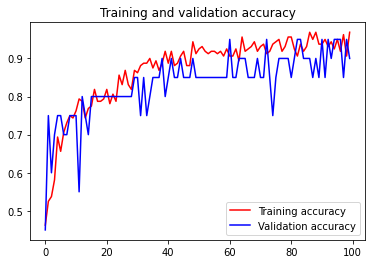

<Figure size 432x288 with 0 Axes>

In [ ]:
#Plotting Training VS Validation Accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#Upload test image and use model to predict likelihood of a Hemorrhage
#Outputs the chance that the CT scan detected a brain hemorrhage

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(140, 140))
  x = image.img_to_array(img)
  x = tf.image.rgb_to_grayscale(x)
  x = np.expand_dims(x, axis=0)
  x = x/255.0

  classes = model.predict(x, batch_size=10)
  print(fn)
  print(classes)

Saving hemorrhage.jpg to hemorrhage.jpg
hemorrhage.jpg
[[1.]]
